<h1>Forecasting number of Air Passengers</h1>

# 1. Data preparation

- Importing all the required libraries for analysis

In [5]:

%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

- Download and Read the dataset file and checking the size of file

In [3]:
"""
International Airline Passengers prediction problem.
This is a problem where, given a year and a month, the task is to predict 
the number of international airline passengers in units of 1,000. 
The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.
"""

!wget https://raw.githubusercontent.com/juntaoduan/Time-Series-Analysis_Classical_and_NeuralNet/main/data/AirPassengers.csv

--2021-06-10 19:06:22--  https://raw.githubusercontent.com/juntaoduan/Time-Series-Analysis_Classical_and_NeuralNet/main/data/AirPassengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1745 (1.7K) [text/plain]
Saving to: ‘AirPassengers.csv’

AirPassengers.csv   100%[===================>]   1.70K  --.-KB/s    in 0s      

2021-06-10 19:06:22 (42.3 MB/s) - ‘AirPassengers.csv’ saved [1745/1745]



In [ ]:
data=pd.read_csv('/content/AirPassengers.csv', header = 0,  names = ['Month', 'Passengers'])
data['Month']=pd.to_datetime(data['Month'], infer_datetime_format=True)
data=data.set_index(['Month'])
data

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


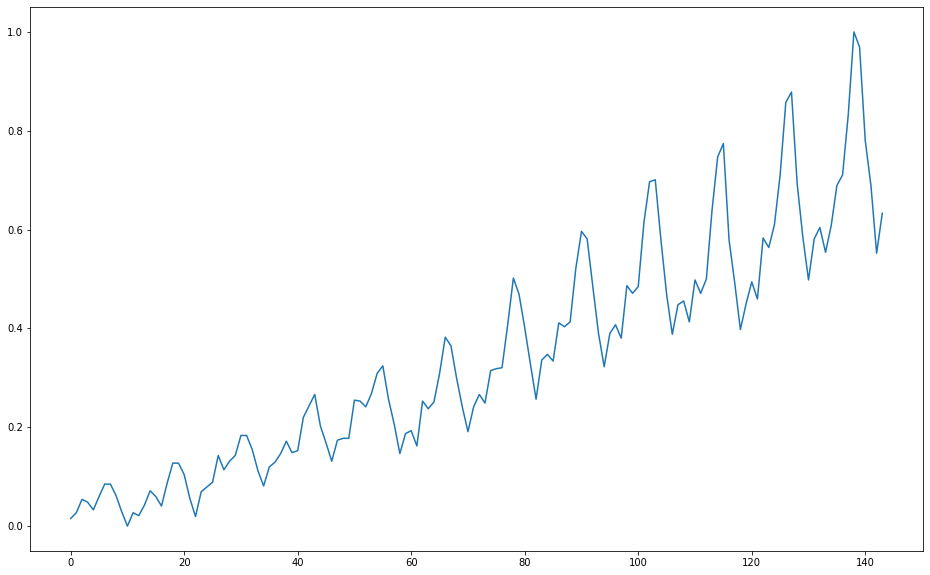

In [18]:
# load the dataset
dataframe = pd.read_csv('AirPassengers.csv', usecols=[1])
dataframe

#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)
plt.figure(figsize=(16,10))
plt.plot(dataset)
plt.show()


#We cannot use random way of splitting dataset into train and test as
#the sequence of events is important for time series.
#So let us take first 60% values for train and the remaining 1/3 for testing
# split into train and test sets
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [22]:
# We cannot fit the model like we normally do for image processing where we have
#X and Y. We need to transform our data into something that looks like X and Y values.
# This way it can be trained on a sequence rather than indvidual datapoints. 
# Let us convert into n number of columns for X where we feed sequence of numbers
#then the final column as Y where we provide the next number in the sequence as output.
# So let us convert an array of values into a dataset matrix

#seq_size is the number of previous time steps to use as 
#input variables to predict the next time period.

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)


seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))    

Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [32]:
def tf_train(model, epochs):
    global trainX, trainY, testX, testY
    model.fit(trainX, trainY, validation_data=(testX, testY),
            verbose=0, epochs=epochs)


    # make predictions

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # invert predictions back to prescaled values
    #This is to compare with original input values
    #SInce we used minmaxscaler we can now use scaler.inverse_transform
    #to invert the transformation.
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))

    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions for plotting
    #we must shift the predictions so that they align on the x-axis with the original dataset. 
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

Single LSTM with hidden Dense...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Train...
Train Score: 18.81 RMSE
Test Score: 42.52 RMSE


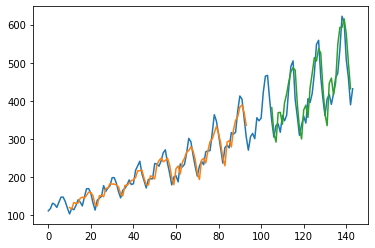

In [35]:
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)
#####################################################
#Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
#                        verbose=1, mode='auto', restore_best_weights=True)
model.summary()
print('Train...')
tf_train(model,100)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, None, 64)          19200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 54,337
Trainable params: 54,337
Non-trainable params: 0
_________________________________________________________________
Train...
Train Score: 18.47 RMSE
Test Score: 41.56 RMSE


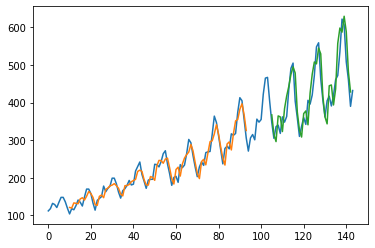

In [39]:
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)
#########################################

#Stacked LSTM with 1 hidden dense layer
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')
tf_train(model,150)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               38400     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 38,529
Trainable params: 38,529
Non-trainable params: 0
_________________________________________________________________
Train...
Train Score: 16.18 RMSE
Test Score: 44.97 RMSE


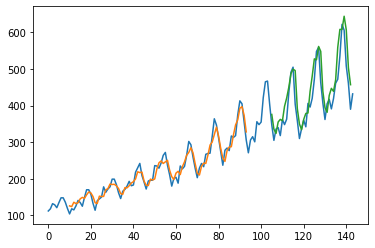

In [42]:
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)
###############################################

#Bidirectional LSTM
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#For some sequence forecasting problems we may need LSTM to learn
# sequence in both forward and backward directions
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(None, seq_size)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
print('Train...')
tf_train(model,200)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________
Train Score: 15.30 RMSE
Test Score: 38.63 RMSE


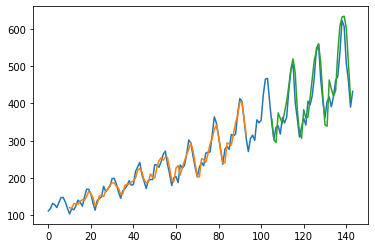

In [43]:
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)
#########################################################
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')

tf_train(model,200)
